### Topic modeling with NMF and LDA

1. Load dataframe of neighborhoods and extract neighborhood descriptions (lemmas)
2. Create vector, complete topic modeling, and assign topic distributions to each neighborhood:
    * NMF
    * LDA
4. Visualize topics with tSNE

Resources:
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py)
* [Practical Topic Finding for Short-Sentence Texts](http://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb)
* [Topic Modeling with Scikit Learn](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730#.gabw32h5e)
* [Improving the Interpretation of Topic Models](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d#.8j9ngyi91)
* [Care and Feeding of Topic Models: Problems, Diagnostics, and Improvements](https://mimno.infosci.cornell.edu/papers/2014_book_chapter_care_and_feeding.pdf)
* [Getting started with Latent Dirichlet Allocation in Python](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [An illustrated introduction to the t-SNE algorithm](https://github.com/oreillymedia/t-SNE-tutorial)

In [1]:
import pickle

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation

import json

import matplotlib.pyplot as plt
%matplotlib inline

#tSNE tutorial imports
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import _joint_probabilities, _kl_divergence
from sklearn.utils.extmath import _ravel

import matplotlib.patheffects as PathEffects

In [2]:
#function to display top words within each topic
def display_topics(model, W, features, n):
    best_hosts = []
    for index, topic in enumerate(model.components_):
        print 'Topic %d:' % index
        print 'TOP %d WORDS:' % n
        for i in topic.argsort()[:-n - 1:-1]:
            print features[i]
        print 'REPRESENTATIVE HOST:'
        ind = np.argsort(W[:,index])[::-1][0]
        best_hosts.append(ind)
        print df_neighborhoods.iloc[ind][['neighborhood', 'city', 'state']]
        print
    return best_hosts

In [68]:
#parameters for topic models
num_topics = 16
num_top_words = 8

#### Load AirBnB neighborhoods dataframe and extract preprocessed neighborhood descriptions

In [4]:
with open('../data/interim/04_neighborhoods_lemmas.pkl', 'rb') as picklefile:
    df_neighborhoods = pickle.load(picklefile)

In [5]:
lemmas = df_neighborhoods['lemmas']

In [6]:
neighborhoods = df_neighborhoods['neighborhood'].tolist()
cities = df_neighborhoods['city'].tolist()
states = df_neighborhoods['state'].tolist()
loc = zip(neighborhoods, cities, states)

### NMF (sklearn)

#### Create TFIDF vector using neighborhood descriptions

In [51]:
nmf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.75,
                                 min_df=20,
                                 max_features = 1000)

tfidf = nmf_vectorizer.fit_transform(lemmas)
nmf_features = nmf_vectorizer.get_feature_names()
len(nmf_features)

1000

In [41]:
#10 words with highest tfidf
top = nmf_vectorizer.idf_.argsort()[:10].tolist()
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in top]

[(u'friendly', 1.2936522394382846),
 (u'include', 1.2936522394382846),
 (u'love', 1.2951503670593068),
 (u'bus', 1.2981533723190763),
 (u'market', 1.2981533723190763),
 (u'offer', 1.3194307707663613),
 (u'ride', 1.3194307707663613),
 (u'enjoy', 1.3333521092849692),
 (u'go', 1.360188763238529),
 (u'residential', 1.3617900446055029)]

In [42]:
#10 words with lowest tfidf
bottom = nmf_vectorizer.idf_.argsort()[::-1].tolist()[:20]
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in bottom]

[(u'frenchman', 4.7534179752515069),
 (u'museum botanical', 4.6624461970457807),
 (u'tokyo', 4.3967430313127753),
 (u'dodger', 4.3967430313127753),
 (u'km', 4.2715798883587688),
 (u'rockefeller', 4.2144214745188204),
 (u'botanic', 4.2144214745188204),
 (u'arboretum', 4.1870225003307056),
 (u'natural history', 4.1870225003307056),
 (u'esplanade', 4.134378766845284),
 (u'childrens museum', 4.134378766845284),
 (u'fifth', 4.0602707946915615),
 (u'caribbean', 3.9477928112648719),
 (u'sand', 3.8466966943935033),
 (u'fest', 3.8466966943935033),
 (u'sculpture', 3.8089563664106558),
 (u'westside', 3.8089563664106558),
 (u'flea market', 3.7906072277424596),
 (u'institute', 3.7548891451403801),
 (u'latino', 3.7374974024285113)]

#### Extract topics using NMF on TFIDF vector of host descriptions
* Number of components set to number of topics
* init set to Nonnegative Double Singular Value Decomposition (nndsvd), which is better for sparse matrices
* solver set to cd (recommended in documentation)

In [69]:
nmf = NMF(n_components=num_topics,
          init='nndsvd',
          solver = 'cd',
          random_state=16)
nmf_doc_topic = nmf.fit_transform(tfidf)
nmf_doc_topic.shape

(895, 16)

In [70]:
nmf_topic_word = nmf.components_
nmf_topic_word.shape

(16, 1000)

In [71]:
best_nmf_hosts = display_topics(nmf, nmf_doc_topic, nmf_features, num_top_words)

Topic 0:
TOP 8 WORDS:
music
coffee shop
venue
taco
hip
cafe
favorite
bike
REPRESENTATIVE HOST:
neighborhood    Bellmont Hillsboro
city                     nashville
state                           TN
Name: 94, dtype: object

Topic 1:
TOP 8 WORDS:
apartment
building
step
famous
boutique
nightlife
low
attraction
REPRESENTATIVE HOST:
neighborhood    Near North
city               chicago
state                   IL
Name: 999, dtype: object

Topic 2:
TOP 8 WORDS:
freeway
airport
major
centrally
neighbor
movie
nice
residential
REPRESENTATIVE HOST:
neighborhood    Westchester
city             losangeles
state                    CA
Name: 1653, dtype: object

Topic 3:
TOP 8 WORDS:
museum
science
art museum
art
academy
hospital
aquarium
botanical
REPRESENTATIVE HOST:
neighborhood    Carnegie Hill
city              newyorkcity
state                      NY
Name: 207, dtype: object

Topic 4:
TOP 8 WORDS:
market
farmer
farmer market
sunday
cafe
saturday
bakery
market sunday
REPRESENTATIVE HOST:
neig

#### A couple visualizations!

In [86]:
nmf_topics = ['tacos music coffee', 'urban nightlife', 'easy car access', \
            'museums', 'farmers markets', 'campus life', 'diverse residential urban', \
            'streetcars jazz', 'sports', 'golf tennis', 'subway', 'beach water activities', \
            'trail hike nature', 'art galleries culture', 'food carts bikes']

In [72]:
len(nmf_topic_word[0])

1000

In [57]:
#plot importance of each word for each topic (1 plot per topic)
def plot_word_prob(topics, topic_word):
    f, ax= plt.subplots(len(topics), 1, figsize=(8, 24), sharex=True)
    x_min = -50
    x_max = len(topic_word[0]) + 50
    y_min = 0
    
    for i, k in enumerate(topics):
        y_max = round(max(topic_word[i])*1.1, 1)
        ax[i].stem(topic_word[i], linefmt='b-', markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("topic {}".format(k))

    plt.tight_layout()
    plt.show()

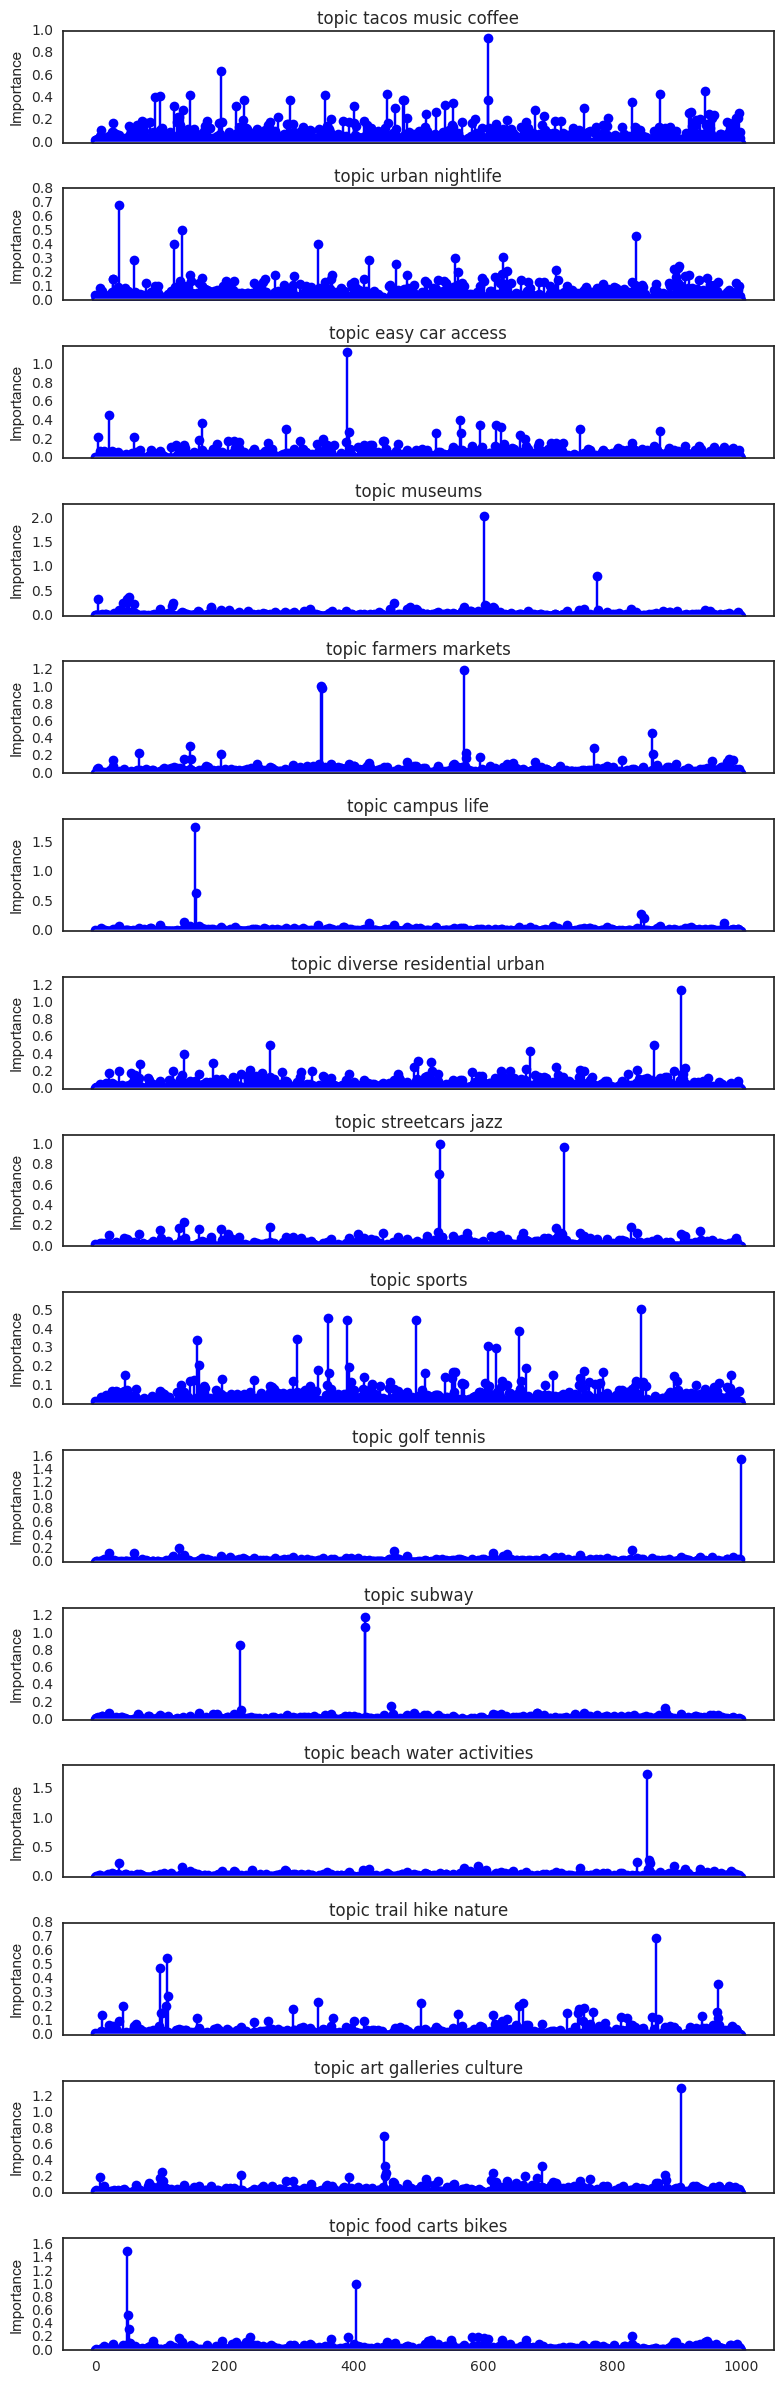

In [87]:
plot_word_prob(nmf_topics, nmf_topic_word)

In [17]:
#plot importance of all topics for document most representative of each topic (1 plot per topic)
def plot_doc_prob(best_hosts, doc_topic):
    f, ax= plt.subplots(len(best_hosts), 1, figsize=(8, 24), sharex=True)
    x_min = -1
    x_max = len(best_hosts)
    y_min = 0
    y_max = max(1, round(max(doc_topic.flatten())*1.1, 1))
    
    for i, k in enumerate(best_hosts):
        ax[i].stem(doc_topic[k], linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("Document {}".format(k))

    plt.tight_layout()
    plt.show()

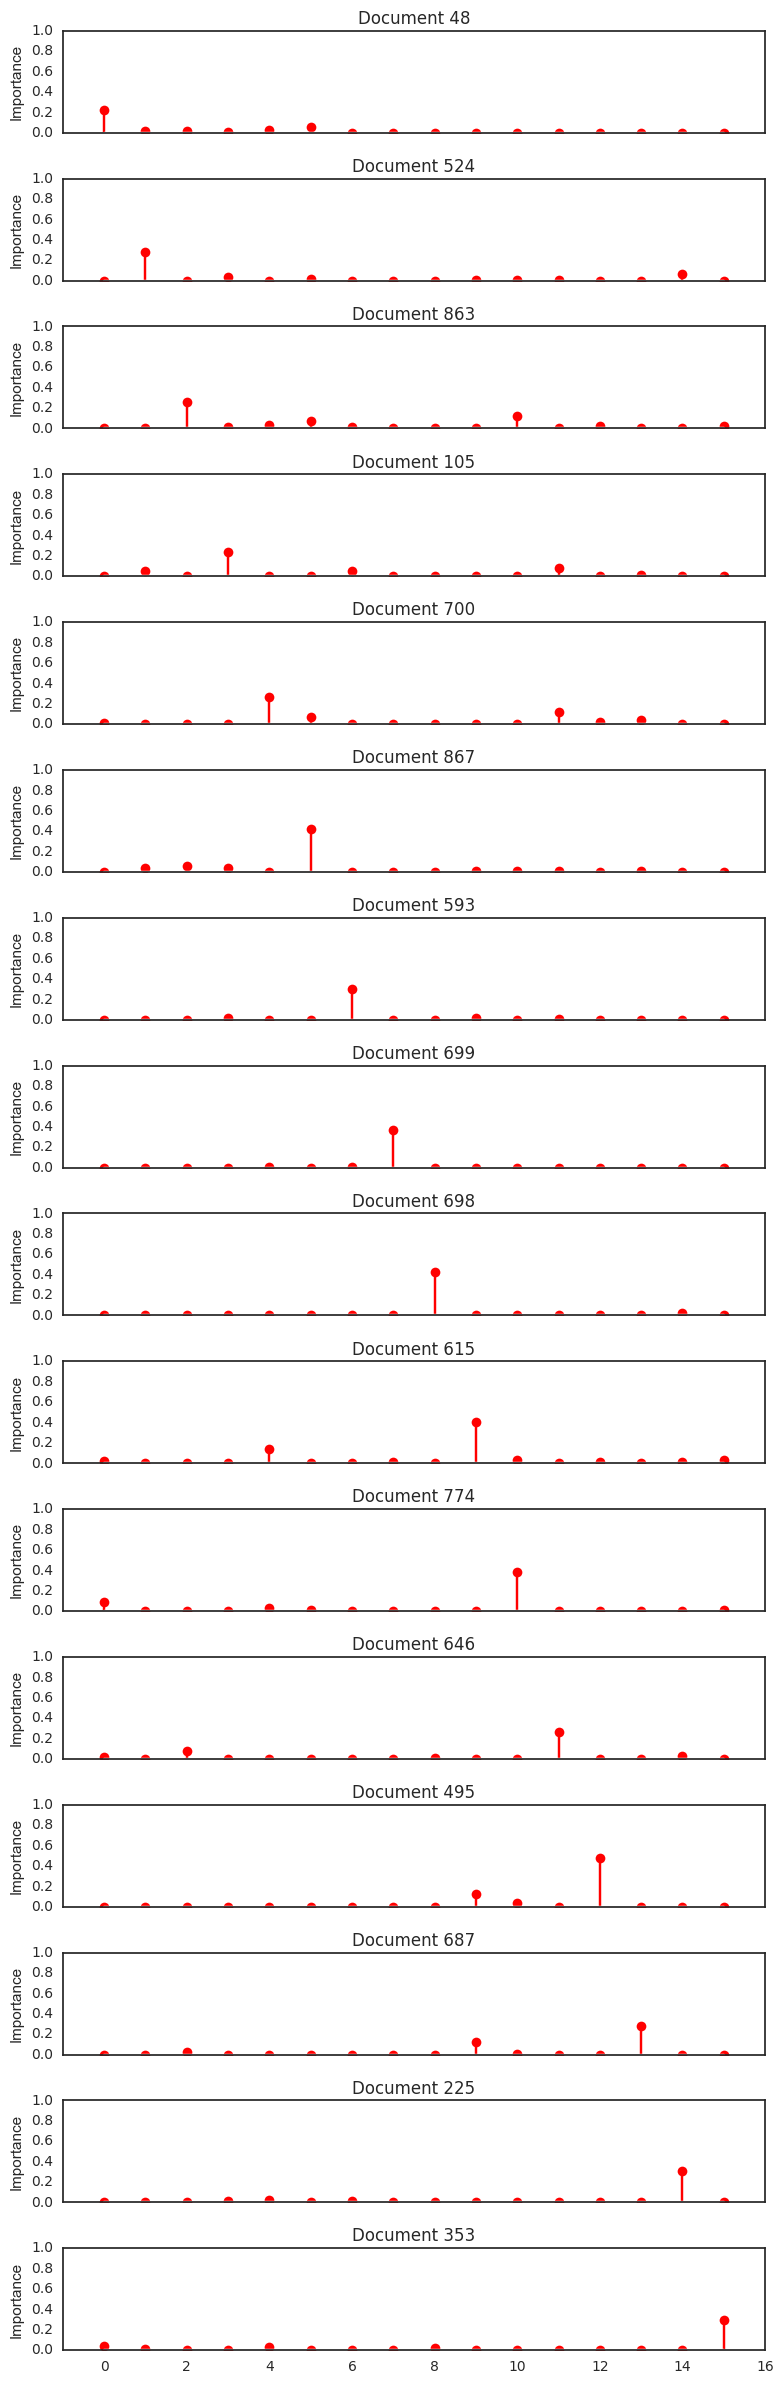

In [76]:
plot_doc_prob(best_nmf_hosts, nmf_doc_topic)

#### Assign clusters

In [97]:
df_topics = pd.DataFrame(nmf_doc_topic)

In [98]:
df_topics['topic_num'] = df_topics.idxmax(axis=1)

In [99]:
df_topics['topic'] = df_topics['topic_num'].map(pd.Series(nmf_topics))

In [100]:
df_topics['neighborhood'] = df_neighborhoods['neighborhood']
df_topics['city'] = df_neighborhoods['city']

In [101]:
with open('../data/interim/05_nmf_topics.pkl', 'wb') as picklefile:
    pickle.dump(df_topics, picklefile)

#### Visualizations for presenting

In [19]:
import seaborn as sns
sns.set_style('white')

In [20]:
viz_topics = {0: 1, 1: 4}

In [21]:
def plot_for_viz(index, topic, topic_word, features):
    #print features[topic_word[index].argmax()[:3]]
    
    f, ax= plt.subplots(1, 1, figsize=(8, 2), sharex=True)
    x_min = -10
    x_max = len(topic_word[0])+10
    y_min = 0
    y_max = round(max(topic_word[index])*1.1, 1)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    markerline, stemlines, baseline = ax.stem(topic_word[index]) #, linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(markerline, 'color', '#595959')
    plt.setp(stemlines, 'color', '#595959')
    plt.setp(baseline, 'color', '#595959')
    
    plt.tight_layout()
    plt.show()

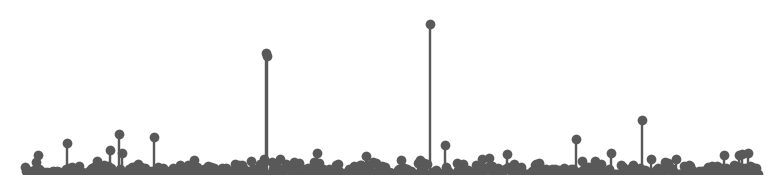

In [22]:
plot_for_viz(4, 'outdoorsy', nmf_topic_word, nmf_features)

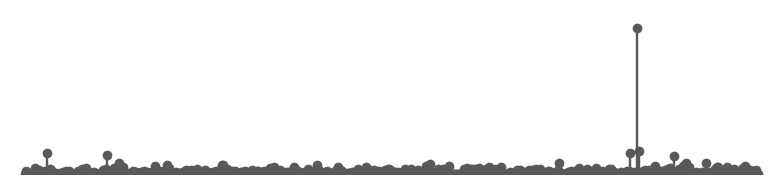

In [23]:
plot_for_viz(1, 'professional', nmf_topic_word, nmf_features)

#### Assign topic distribution to each listing

#### Pickle nmf topics dataframe

### LDA (sklearn)

#### Create term frequency vector using host descriptions (stopwords removed)

In [60]:
lda_vectorizer = CountVectorizer(#strip_accents = 'unicode',
                                #stop_words = 'english',
                                #lowercase = True,
                                #token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_features = 1000,
                                ngram_range=(1,2),
                                max_df = 0.75, 
                                min_df = 20)
counts = lda_vectorizer.fit_transform(lemmas)
lda_features = lda_vectorizer.get_feature_names()
len(lda_features)

1000

#### Extract topics using LDA on counts vector of host descriptions
* Number of components set to number of topics
* Learning method set to online for better performance

In [61]:
lda = LatentDirichletAllocation(n_topics=num_topics,
                                learning_method='online',
                                random_state=16)
lda_doc_topic = lda.fit_transform(counts)

In [62]:
lda_topic_word = lda.components_

In [63]:
best_lda_hosts = display_topics(lda, lda_doc_topic, lda_features, num_top_words)

Topic 0:
TOP 8 WORDS:
museum
bus
campus
public
car
art
zoo
residential
REPRESENTATIVE HOST:
neighborhood    North West Hawthorne
city                      losangeles
state                             CA
Name: 1062, dtype: object

Topic 1:
TOP 8 WORDS:
apartment
subway
museum
time
building
famous
attraction
art
REPRESENTATIVE HOST:
neighborhood        Midtown
city            newyorkcity
state                    NY
Name: 928, dtype: object

Topic 2:
TOP 8 WORDS:
train
subway
diverse
people
apartment
cafe
stop
supermarket
REPRESENTATIVE HOST:
neighborhood       Woodside
city            newyorkcity
state                    NY
Name: 1703, dtype: object

Topic 3:
TOP 8 WORDS:
museum
market
subway
apartment
farmer
farmer market
cafe
include
REPRESENTATIVE HOST:
neighborhood    Capitol Hill
city            washingtondc
state                     DC
Name: 200, dtype: object

Topic 4:
TOP 8 WORDS:
bike
market
trail
coffee shop
hike
farmer
farmer market
friendly
REPRESENTATIVE HOST:
neighborhood  

#### Visualizations

In [64]:
lda_topics = range(num_topics)

In [65]:
lda_topic_word_norm = lda_topic_word/np.sum(lda_topic_word, axis=1, keepdims=True)

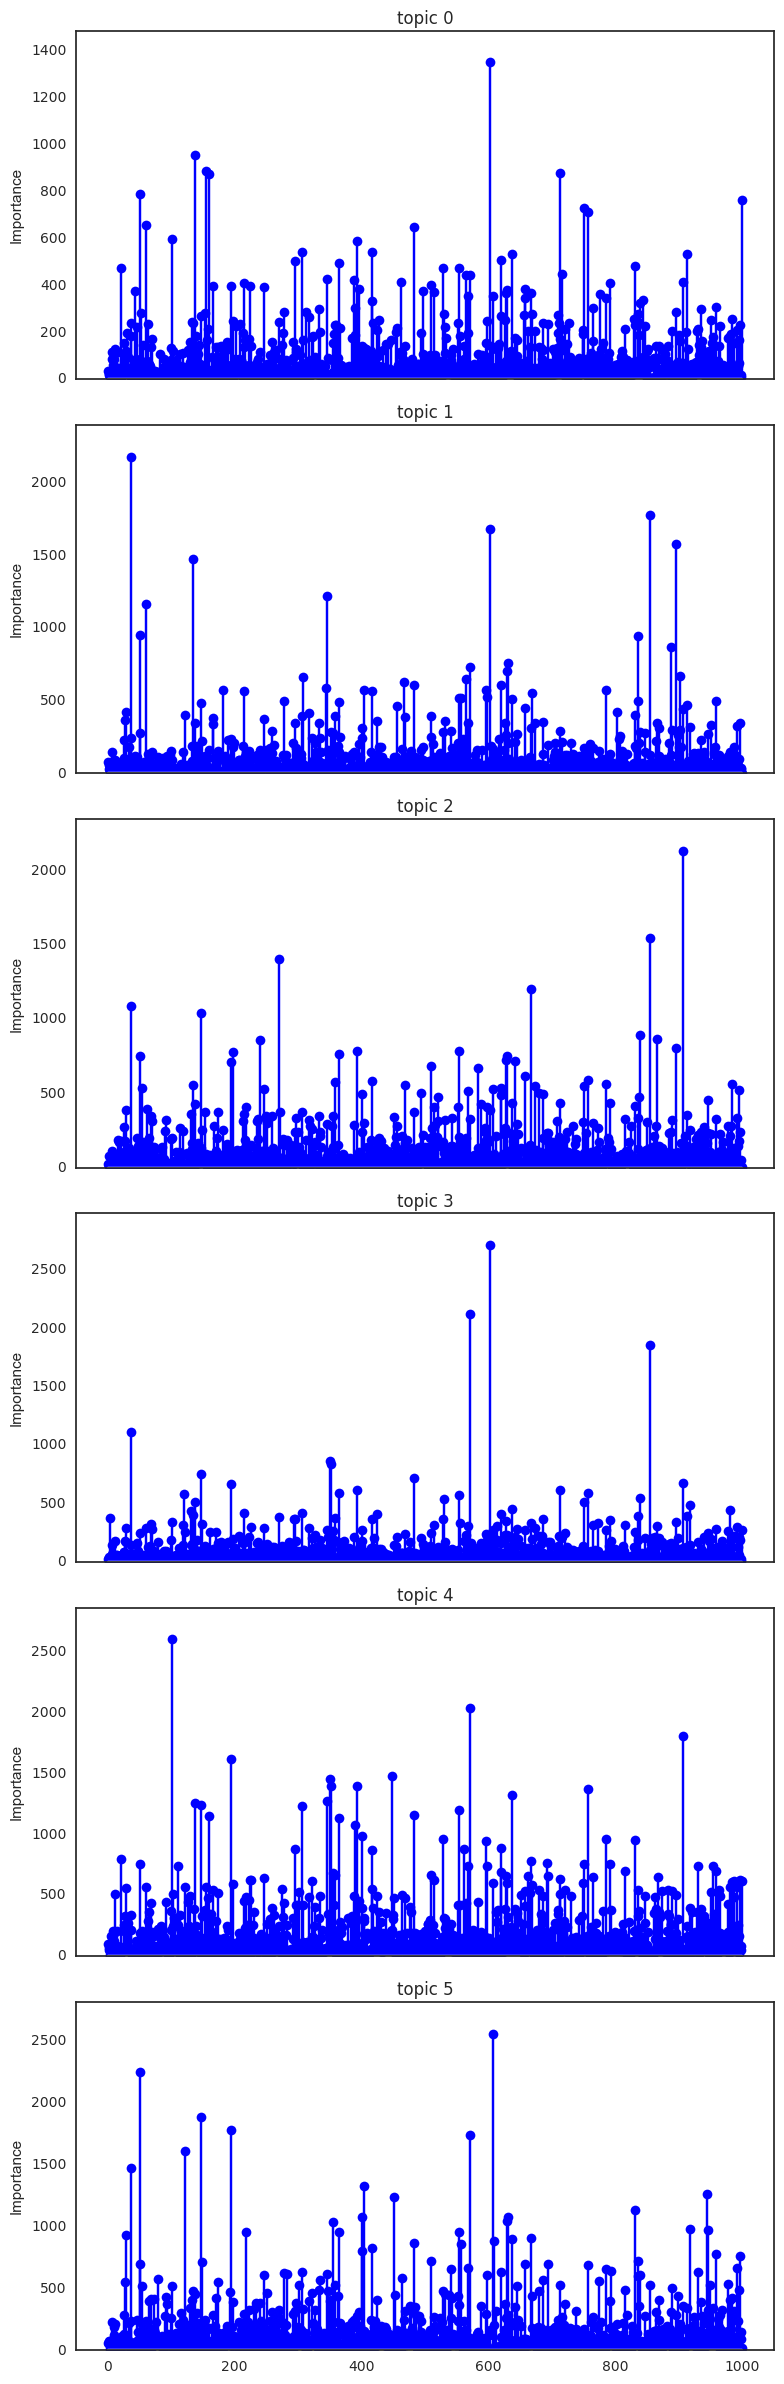

In [66]:
plot_word_prob(lda_topics, lda_topic_word)

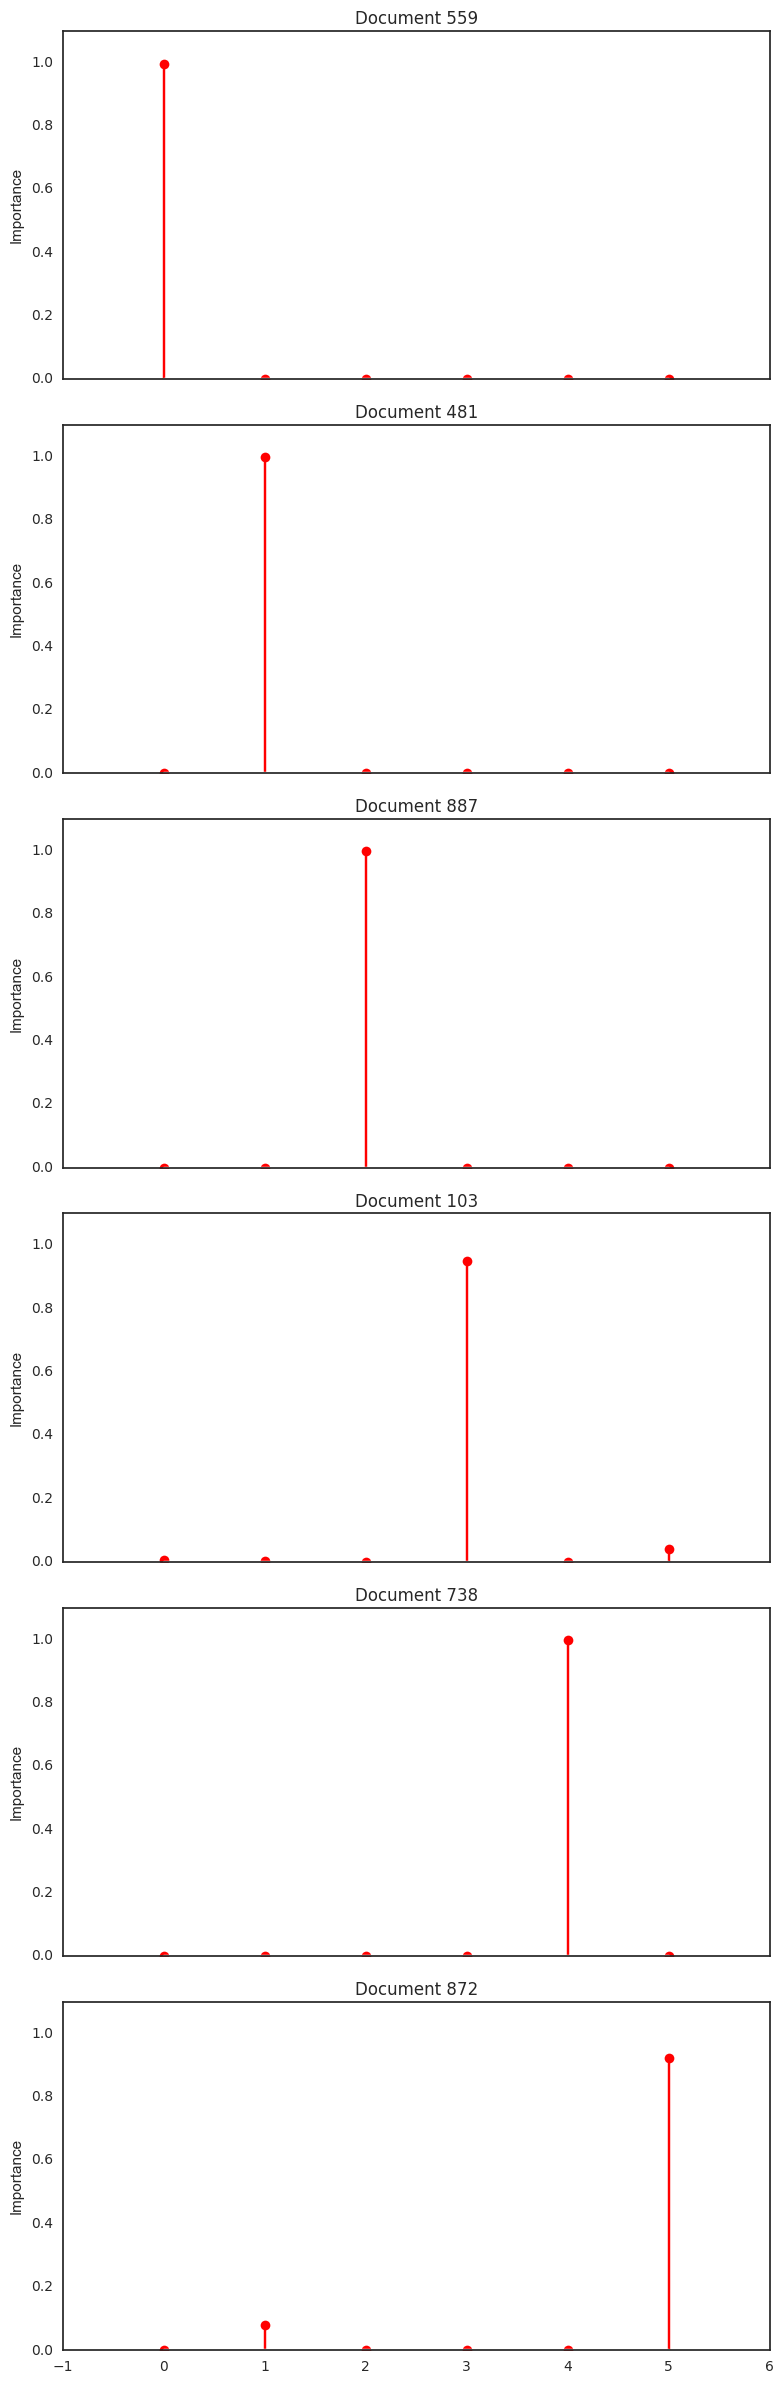

In [67]:
plot_doc_prob(best_lda_hosts, lda_doc_topic)

#### Visualizations for presenting

In [ ]:
plot_for_viz(9, 'outdoorsy', lda_topic_word, lda_features)

In [ ]:
plot_for_viz(10, 'professional', lda_topic_word, lda_features)

#### Assign topic distribution to each listing

In [ ]:
lda_topics = pd.DataFrame(lda_doc_topic, columns=lda_topics)

In [ ]:
lda_topics.head()

#### Pickle lda topics dataframe

In [ ]:
with open('../data/interim/lda_topics.pkl', 'wb') as picklefile:
    pickle.dump(lda_topics, picklefile)